In [1]:
# ------------------------------------------------------------------------------
# An example of training and evaluating a model for the prostate dataset in the
# Medical Segmentation Decathlon. To execute, download the data for task 5 from
# http://medicaldecathlon.com/ and specify the path in mp.paths.py. 
# ------------------------------------------------------------------------------

# 1. Imports

# Reload changes modules
from IPython import get_ipython
get_ipython().magic('load_ext autoreload') 
get_ipython().magic('autoreload 2')

# Import modules
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from mp.experiments.experiment import Experiment
from mp.data.data import Data
from mp.data.datasets.ds_mr_prostate_decathlon import DecathlonProstateT2
import mp.visualization.visualize_imgs as vis
from mp.data.pytorch.pytorch_seg_dataset import PytorchSeg2DDataset
from mp.models.segmentation.unet_fepegar import UNet2D
from mp.eval.losses.losses_segmentation import LossClassWeighted, LossDiceBCE
from mp.agents.segmentation_agent import SegmentationAgent
from mp.eval.result import Result
from mp.utils.load_restore import nifty_dump

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Link: https://arxiv.org/abs/2003.04696



In [2]:
# 2. Define configuration

# The configuration dictionary boundles training parameters and anything 
# that can be manually defined. The config file is stored within the directory 
# created for a given experiment. By specifying arguments in config files, 
# higher-level modules don't need to be adapted for hyperparameter searches
# and experiments are more easily reproducible.

config = {'experiment_name':'test_exp', 'device':'cuda:0',
    'nr_runs': 1, 'cross_validation': False, 'val_ratio': 0.0, 'test_ratio': 0.3,
    'input_shape': (1, 256, 256), 'resize': False, 'augmentation': 'none', 
    'class_weights': (0.,1.), 'lr': 0.0001, 'batch_size': 8
    }
device = config['device']
device_name = torch.cuda.get_device_name(device)
print('Device name: {}'.format(device_name))
input_shape = config['input_shape']  

Device name: GeForce GTX 1050 Ti


In [4]:
# 3. Create experiment directories

# Initializing an experiment creates a directory exp/<exp name> in the
# storage directory defined in mp.paths.py. All files created during that 
# experiment are stored there.
exp = Experiment(config=config, name=config['experiment_name'], notes='', reload_exp=True)

In [5]:
# 4. Define data

# A data object can be initialized with multiple datasets. The idea behind this
# is to more easily test with o.o.d data, or simulate continual learning.
# In this example, we only add one dataset.
data = Data()
data.add_dataset(DecathlonProstateT2(merge_labels=True))
nr_labels = data.nr_labels
label_names = data.label_names
train_ds = ('DecathlonProstateT2', 'train')
test_ds = ('DecathlonProstateT2', 'test')


DATASET: DecathlonProstateT2 with 32 instances
Mean shape: (1, 316, 316, 18), shape std: (0, 22, 22, 2)
Mask labels: [&#39;background&#39;, &#39;prostate&#39;]



In [6]:
# 5. Create data splits for each repetition

# For each dataset, the instance indexes are divided into train, validation
# and test sets. The values specified in the config are used to determine
# the number of runs and how indexes are divided. For more details, look at the
# method definition for 'set_data_splits'. The index splitting is also stored 
# within the experiment directory. For each repetition, a subdirectory is 
# created named after the repetition index.
exp.set_data_splits(data)

# Get the experiment run respective to the first data split. This would usually 
# be repeated for all 'nr_runs' runs
exp_run = exp.get_run(run_ix=0)

In [7]:
# 6. Bring data to Pytorch format

# Transform data to PyTorch format
datasets = dict()
for ds_name, ds in data.datasets.items():
    for split, data_ixs in exp.splits[ds_name][exp_run.run_ix].items():
        if len(data_ixs) > 0: # Sometimes val indexes may be an empty list
            aug = config['augmentation'] if not('test' in split) else 'none'
            datasets[(ds_name, split)] = PytorchSeg2DDataset(ds, 
                ix_lst=data_ixs, size=input_shape, aug_key=aug, 
                resize=config['resize'])
# Visualize the first instance from the training data
subject_ix = 0
subject = datasets[train_ds].instances[subject_ix].get_subject()
vis.plot_3d_subject_gt(subject)

In [8]:
# 7. Build train dataloader, and visualize

dl = DataLoader(datasets[(train_ds)], 
    batch_size=config['batch_size'], shuffle=True)
vis.visualize_dataloader_with_masks(dl, img_size=(128, 128))

In [9]:
# 8. Initialize model

model = UNet2D(input_shape, nr_labels)
model.to(device)

UNet2D(
  (encoder): Encoder(
    (encoding_blocks): ModuleList(
      (0): EncodingBlock(
        (conv1): ConvolutionalBlock(
          (conv_layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation_layer): ReLU()
          (block): Sequential(
            (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU()
          )
        )
        (conv2): ConvolutionalBlock(
          (conv_layer): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm_layer): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation_layer): ReLU()
          (block): Sequential(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (downsample): MaxPool2d(kernel_size=2, stride=2, paddi

In [10]:
# 9. Define loss and optimizer

# Define loss and optimizer. In this case, the loss is a combination of Dice
# and binary cross-entropy, weighted so that only the dice on the 'prostate'
# class is considered and not that for 'background'
loss_g = LossDiceBCE(bce_weight=1., smooth=1., device=device)
loss_f = LossClassWeighted(loss=loss_g, weights=config['class_weights'], 
    device=device)
optimizer = optim.Adam(model.parameters(), lr=config['lr'])

In [11]:
# 10. Train model

# We train here only for 10 epochs for testing purposes, altough in practice
# many more are necessary to reach convergence
results = Result(name='training_trajectory')   
agent = SegmentationAgent(model=model, label_names=label_names, device=device)
agent.train(results, optimizer, loss_f, train_dataloader=dl,
    init_epoch=0, nr_epochs=10, run_loss_print_interval=5,
    eval_datasets=datasets, eval_interval=5, 
    save_path=exp_run.paths['states'], save_interval=5)

Epoch 0 dataset (&#39;DecathlonProstateT2&#39;, &#39;train&#39;)
Loss_LossClassWeighted[loss=LossCombined[1.0xLossDice[smooth=1.0]+1.0xLossBCE]; weights=(0.0, 1.0)]: 1.5473218692242912
Loss_LossCombined[1.0xLossDice[smooth=1.0]+1.0xLossBCE][0]: 0.9132229618862113
Loss_LossCombined[1.0xLossDice[smooth=1.0]+1.0xLossBCE][1]: 1.5473218692242912
ScoreDice: 0.46513506322135806
ScoreIoU: 0.39571227202250175
ScoreDice[background]: 0.8585674187014544
ScoreIoU[background]: 0.7533623757627844
ScoreDice[prostate]: 0.07170270774126192
ScoreIoU[prostate]: 0.0380621682822191
Epoch 0 dataset (&#39;DecathlonProstateT2&#39;, &#39;test&#39;)
Loss_LossClassWeighted[loss=LossCombined[1.0xLossDice[smooth=1.0]+1.0xLossBCE]; weights=(0.0, 1.0)]: 1.5391011298003823
Loss_LossCombined[1.0xLossDice[smooth=1.0]+1.0xLossBCE][0]: 0.910014008139119
Loss_LossCombined[1.0xLossDice[smooth=1.0]+1.0xLossBCE][1]: 1.5391011298003823
ScoreDice: 0.4732915197648023
ScoreIoU: 0.4039635342939699
ScoreDice[background]: 0.86686878

Last Dice score for prostate class: 0.7364828082510707


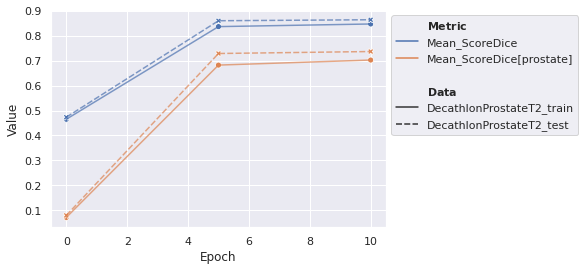

In [12]:
# 11. Save and print results for this experiment run

exp_run.finish(results=results, plot_metrics=['Mean_ScoreDice', 'Mean_ScoreDice[prostate]'])
test_ds_key = '_'.join(test_ds)
metric = 'Mean_ScoreDice[prostate]'
last_dice = results.get_epoch_metric(
    results.get_max_epoch(metric, data=test_ds_key), metric, data=test_ds_key)
print('Last Dice score for prostate class: {}'.format(last_dice))

In [13]:
# 12. Visualize results qualitatively

# Visualize result for the first subject in the test dataset
subject_ix = 0
subject = datasets[test_ds].instances[subject_ix].get_subject()
pred = datasets[test_ds].predictor.get_subject_prediction(agent, subject_ix)
vis.plot_3d_subject_pred(subject, pred)